In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
from pathlib import Path
import json

# Functions

In [2]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [3]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tt = line.get_table()
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [4]:
class SweepLosses:
    def __init__(self, line, sweep, plane, num_turns, num_particles=100, nemitt_x=3.5e-6, nemitt_y=3.5e-6, result_name=None, dir=None, gaussian=False):
        self.line = line
        self.plane = plane
        self.sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
        self.num_turns = num_turns
        self.sweep_per_turn = self.sweep/self.num_turns

        self.num_particles = num_particles
        self.gaussian = gaussian

        self.nemitt_x = nemitt_x
        self.nemitt_y = nemitt_y
        if dir is None:
            self.dir = Path.cwd
        else:
            self.dir = dir

        if result_name is None:
            print("WARNING: No result_name provided, using default 'sweep_losses'")
            self.result_name = 'sweep_losses'
        else:
            self.result_name = result_name
        
        self.savedir = Path(self.dir/self.result_name/self.plane)
        Path(self.savedir).mkdir(parents=True, exist_ok=True)
        
        self.track()

    def make_particles(self):
        if not self.gaussian:
            x_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))
            y_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))

            X, Y = np.meshgrid(x_spacing, y_spacing, indexing='xy')
            x_norm = X.ravel()
            y_norm = Y.ravel()

            px_norm = np.zeros_like(x_norm)
            py_norm = np.zeros_like(x_norm)
            tw = self.line.twiss()
            zeta = np.ones_like(x_norm)*tw.particle_on_co.zeta
            delta = np.ones_like(x_norm)*tw.particle_on_co.delta

            return self.line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y, zeta=zeta, delta=delta)
        else:
            return xp.generate_matched_gaussian_bunch(nemitt_x=self.nemitt_x,
                                          nemitt_y=self.nemitt_y,
                                          sigma_z=0.224, num_particles=self.num_particles, line=self.line)

    def track(self):
        tw = self.line.twiss()
        tt = self.line.get_table()
        self.line.collimators.assign_optics(nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y)
        self.part = self.make_particles()

        self.line.discard_tracker()
        self.line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
        rf_sweep = xc.RFSweep(self.line)
        rf_sweep.prepare(sweep_per_turn=self.sweep/self.num_turns)
        rf_sweep.info()
        self.line.scattering.enable()
        self.line.track(particles=self.part, num_turns=self.num_turns, time=True, with_progress=5)
        self.line.scattering.disable()
        print(f"Done sweeping RF in {self.line.time_last_track:.1f}s.")

        self.line.discard_tracker()
        self.line.build_tracker()


    @property
    def aperture_losses(self):
        loss_idxs, loss_counts = np.unique(self.part.at_element, return_counts=True)

        aper_losses = {}
        for idx, count in zip(loss_idxs, loss_counts):
            aper_losses[self.line.element_names[idx]] = int(count)

        json.dump(aper_losses, open(Path(self.savedir)/f'{self.result_name}_aper_losses.json', 'w'), indent=4)
        return aper_losses
    
    @property
    def plot_lossmap(self):
        self.ThisLM = xc.LossMap(self.line, line_is_reversed=False, part=self.part, interpolation=False)
        self.ThisLM.to_json(Path(self.savedir/f'LM_{self.result_name}.json'))
        self.ThisLM.plot(savefig=Path(self.savedir/f'LM_{self.result_name}.pdf'))
    
    @property
    def intensity_loss(self):
        fig, ax = plt.subplots(figsize=(12,6))
        turns, counts = np.unique(self.part.at_turn, return_counts=True)
        dic = {int(turn): int(count) for turn, count in zip(turns, counts)}
        dic['num_particles'] = self.num_particles
        dic['sweep_per_turn'] = self.sweep_per_turn
        json.dump(dic, open(Path(self.savedir)/f'IntensityLoss_{self.result_name}.json', 'w'), indent=4)
        ax.plot(df_to_delta(self.sweep_per_turn*turns)*1e3, 1-np.cumsum(counts)/self.num_particles, marker='o', color='royalblue')
        ax.grid()
        ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
        ax.set_ylabel('Normalised lost intensity', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        fig.tight_layout()
        fig.savefig(Path(self.savedir/f'IntensityLoss_{self.result_name}.pdf'), dpi=300)
        plt.show()
        return turns, counts
    

    def plot_loss_histogram(self, title="Losses per Element", top_n=None):
        # Optionally limit to top N elements by count
        aper_losses = self.aperture_losses
        items = sorted(aper_losses.items(), key=lambda x: x[1], reverse=True)
        if top_n is not None:
            items = items[:top_n]

        elements, counts = zip(*items)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(range(len(elements)), counts, color="steelblue")
        ax.set_xticks(range(len(elements)))
        ax.set_xticklabels(elements, rotation=90)
        ax.set_xlabel("Element name")
        ax.set_ylabel("Number of losses")
        ax.set_title(title)
        fig.tight_layout()

        return fig, ax

# Tests

In [6]:
bump_strengths = {
    'qd.20110':    {13407:1.5589935904933782e-05, 13607:3.5635381547253456e-06, 20207:3.418625982439421e-06, 20407:1.567562976438611e-05},
    'qd.31110':    {30807:1.5590802619432703e-05, 31007:3.5456921731693863e-06, 31207:3.4139073747461334e-06, 31407:1.567463118354537e-05},
    'qd.50110':    {43407:1.5589936379618205e-05, 43607:3.563535125878156e-06, 50207:3.4186259823622525e-06, 50407:1.5675629764448406e-05}
    }

In [58]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [55]:
for nn in bump_strengths['qd.31110']:
    line[f'kmdh{nn}'] += bump_strengths['qd.31110'][nn]

In [56]:
tw = line.twiss()
tw4d = line.twiss4d()

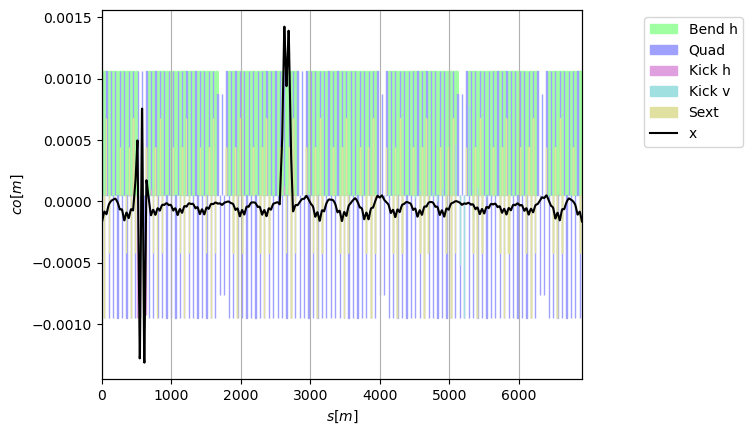

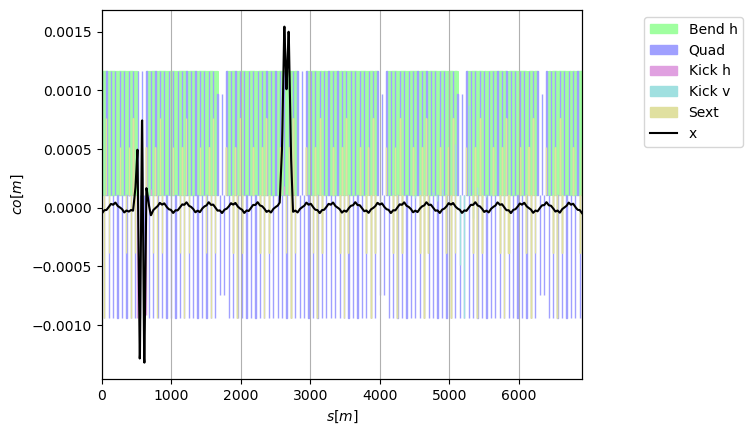

In [57]:
tw.plot('x')
tw4d.plot('x')

In [59]:
quad = 'qd.31110'

for nn in bump_strengths[quad]:
    line[f'bump.{nn}'] = bump_strengths[quad][nn]
    line.ref[f'mdh.{nn}'].knl[0] += line.vars[f'bump.{nn}']

tw = line.twiss()

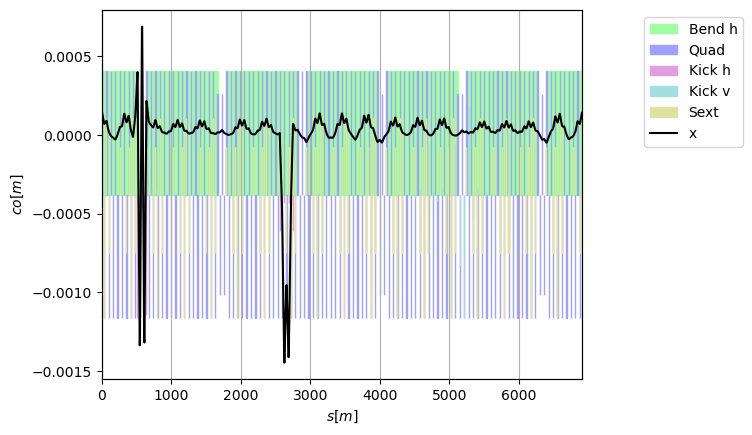

In [60]:
tw.plot('x')

In [32]:
def create_bump(line, tw, at, pos, scale=1):
    left, mid, right = pos
    all_correctors = list(tw.rows['mdh\..*'].name)
    correctors  = (all_correctors + list(tw.rows[:mid].rows['mdh\..*'].name))[-2:]  # To allow wrapping around line
    correctors += (list(tw.rows[mid:].rows['mdh\..*'].name) + all_correctors)[:2]
    corrector_knobs = [f"kmdh{nn.split('.')[-1]}" for nn in correctors]
    if at == mid:
        # Bump 1mm@mid
        targets=[
            xt.TargetSet(x=0, px=0, at=xt.END),
            xt.TargetSet(x=1.485e-3*scale, at=left),
            xt.TargetSet(x=1.485e-3*scale, at=right),
        ]
    else:
        assert at == left or at == right
        at2 = right if at == left else left
        # Bump 1mm@right
        targets=[
            xt.TargetSet(x=0, px=0, at=xt.END),
            xt.TargetSet(x=1.e-3*scale, at=at),
            xt.TargetSet(x=.2e-3*scale, at=at2),
        ]
    opt = line.match(start=correctors[0], end=tw.name[tw.rows.indices[correctors[-1]][0]+20],
                    vary=xt.VaryList(corrector_knobs, step=1.e-7),
                    betx=1, bety=1, x=0, px=0,
                    targets=targets, solve=False)
    opt.solve()
    return opt.actions[0].run(), opt

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_18223/728698718.py:3: SyntaxWarning: invalid escape sequence '\.'
  all_correctors = list(tw.rows['mdh\..*'].name)
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_18223/728698718.py:4: SyntaxWarning: invalid escape sequence '\.'
  correctors  = (all_correctors + list(tw.rows[:mid].rows['mdh\..*'].name))[-2:]  # To allow wrapping around line
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_18223/728698718.py:5: SyntaxWarning: invalid escape sequence '\.'
  correctors += (list(tw.rows[mid:].rows['mdh\..*'].name) + all_correctors)[:2]


# Tests with different knobs

In [61]:
bump_strengths = {
    'qd.20110':    {13407:1.5589935904933782e-05, 13607:3.5635381547253456e-06, 20207:3.418625982439421e-06, 20407:1.567562976438611e-05},
    'qd.31110':    {30807:1.5590802619432703e-05, 31007:3.5456921731693863e-06, 31207:3.4139073747461334e-06, 31407:1.567463118354537e-05},
    'qd.50110':    {43407:1.5589936379618205e-05, 43607:3.563535125878156e-06, 50207:3.4186259823622525e-06, 50407:1.5675629764448406e-05}
    }

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


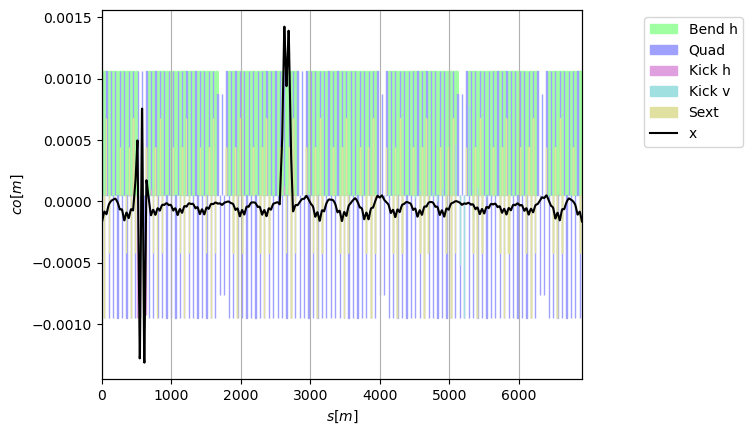

In [62]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

for nn in bump_strengths['qd.31110']:
    line[f'kmdh{nn}'] += bump_strengths['qd.31110'][nn]

tw = line.twiss()
tw.plot('x')

In [66]:
for nn in bump_strengths['qd.31110']:
    print(nn, line.ref[f'mdh.{nn}'].knl[0]._value, line[f'kmdh{nn}'], bump_strengths['qd.31110'][nn])

30807 -1.5590802619432703e-05 1.5590802619432703e-05 1.5590802619432703e-05
31007 -3.5456921731693863e-06 3.5456921731693863e-06 3.5456921731693863e-06
31207 -3.4139073747461334e-06 3.4139073747461334e-06 3.4139073747461334e-06
31407 -1.567463118354537e-05 1.567463118354537e-05 1.567463118354537e-05


In [68]:
line.ref[f'mdh.{nn}'].knl[0]._expr

((-vars['kmdh31407']) - vars['orbit_corr_mdh.31407_x'])

# Preparing line

No bpms and quad shift for qd.52510 and qd.22510

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_18223/1920072779.py:9: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_18223/1920072779.py:9: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_18223/1920072779.py:13: SyntaxWarning: invalid escape sequence '\.'
  tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipy

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.22e-03 -> 2.88e-04, y_rms: 9.78e-05 -> 1.78e-05
Iteration 1, x_rms: 2.88e-04 -> 2.20e-04, y_rms: 1.78e-05 -> 1.30e-05
Iteration 2, x_rms: 2.20e-04 -> 1.87e-04, y_rms: 1.30e-05 -> 1.08e-05
Iteration 3, x_rms: 1.87e-04 -> 1.58e-04, y_rms: 1.08e-05 -> 8.80e-06
Iteration 4, x_rms: 1.58e-04 -> 1.38e-04, y_rms: 8.80e-06 -> 7.86e-06
Iteration 5, x_rms: 1.38e-04 -> 1.34e-04, y_rms: 7.86e-06 -> 7.45e-06
Iteration 6, x_rms: 1.34e-04 -> 1.28e-04, y_rms: 7.45e-06 -> 5.75e-06
Iteration 7, x_rms: 1.28e-04 -> 1.22e-04, y_rms: 5.75e-06 -> 5.26e-06
Iteration 8, x_rms: 1.22e-04 -> 1.19e-04, y_rms: 5.26e-06 -> 4.43e-06
Iteration 9, x_rms: 1.19e-04 -> 1.16e-04, y_rms: 4.43e-06 -> 4.08e-06


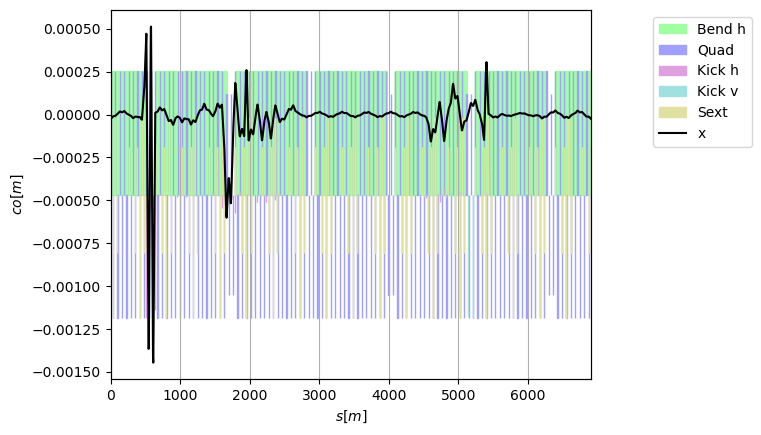

In [81]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

tw_ref = line.twiss4d()
tt = line.get_table()
tt_monitors = tt.rows['bp.*'].rows['.*(?<!_entry)$'].rows['.*(?<!_exit)$']
line.steering_monitors_x = tt_monitors.name
line.steering_monitors_y = tt_monitors.name

tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
mask_ap_h = np.array([el.startswith('Limit') for el in tt_h_correctors.element_type])
line.steering_correctors_x = tt_h_correctors.name[~mask_ap_h]

tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
line.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]

line['qd.52510'].shift_x = 1e-3
line['qd.22510'].shift_x = 1e-3

tw_before = line.twiss4d()
orbit_correction = line.correct_trajectory(twiss_table=tw_ref,n_micado=5, n_iter=10)
tw_after = line.twiss4d()

tw_after.plot('x')

In [82]:
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

In [83]:
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

In [84]:
shifts = {
    'vcak.52501.a_aper' : -1e-3, 
    'vcak.22501.a_aper' : -1e-3, 
    'vcak.52501.b_aper' : -1e-3, 
    'vcak.12501.a_aper' : -1e-3, 
    'vtto.52505.a_aper' : -1e-3, 
    'lsd.52505.a_aper' : -1e-3, 
    'vcak.22501.b_aper' : -1e-3, 
    'vtto.22505.a_aper' : -1e-3
}

for ele in shifts:
    line[ele].shift_x += shifts[ele]

In [85]:
line.to_json('off_mom_scan_line.json')

# HTCondor test code

## Specific sweep class 

Adjust to single core instead of multicore, directory is directly given by the quad, plane and bump so no need for sim name

In [93]:
class SweepLosses:
    def __init__(self, line, sweep, plane, num_turns, num_particles=100, nemitt_x=3.5e-6, nemitt_y=3.5e-6, dir=None, gaussian=False):
        self.line = line
        self.plane = plane
        self.sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
        self.num_turns = num_turns
        self.sweep_per_turn = self.sweep/self.num_turns

        self.num_particles = num_particles
        self.gaussian = gaussian

        self.nemitt_x = nemitt_x
        self.nemitt_y = nemitt_y

        if dir is None:
            self.savedir = Path.cwd
        else:
            self.savedir = dir
        
        Path(self.savedir).mkdir(parents=True, exist_ok=True)
        self.track()

    def make_particles(self):
        if not self.gaussian:
            x_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))
            y_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))

            X, Y = np.meshgrid(x_spacing, y_spacing, indexing='xy')
            x_norm = X.ravel()
            y_norm = Y.ravel()

            px_norm = np.zeros_like(x_norm)
            py_norm = np.zeros_like(x_norm)
            tw = self.line.twiss()
            zeta = np.ones_like(x_norm)*tw.particle_on_co.zeta
            delta = np.ones_like(x_norm)*tw.particle_on_co.delta

            return self.line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y, zeta=zeta, delta=delta)
        else:
            return xp.generate_matched_gaussian_bunch(nemitt_x=self.nemitt_x,
                                          nemitt_y=self.nemitt_y,
                                          sigma_z=0.224, num_particles=self.num_particles, line=self.line)

    def track(self):
        tw = self.line.twiss()
        tt = self.line.get_table()
        self.line.collimators.assign_optics(nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y)
        self.part = self.make_particles()

        rf_sweep = xc.RFSweep(self.line)
        rf_sweep.prepare(sweep_per_turn=self.sweep/self.num_turns)
        rf_sweep.info()
        self.line.scattering.enable()
        self.line.track(particles=self.part, num_turns=self.num_turns, time=True, with_progress=5)
        self.line.scattering.disable()
        print(f"Done sweeping RF in {self.line.time_last_track:.1f}s.")


    @property
    def aperture_losses(self):
        loss_idxs, loss_counts = np.unique(self.part.at_element, return_counts=True)

        aper_losses = {}
        for idx, count in zip(loss_idxs, loss_counts):
            aper_losses[self.line.element_names[idx]] = int(count)

        json.dump(aper_losses, open(Path(self.savedir)/'loss_locations.json', 'w'), indent=4)
        return aper_losses
    
    @property
    def make_lossmap(self):
        self.ThisLM = xc.LossMap(self.line, line_is_reversed=False, part=self.part, interpolation=False)
        self.ThisLM.to_json(Path(self.savedir/f'LM.json'))
    
    @property
    def intensity_loss(self):
        fig, ax = plt.subplots(figsize=(12,6))
        turns, counts = np.unique(self.part.at_turn, return_counts=True)
        dic = {int(turn): int(count) for turn, count in zip(turns, counts)}
        dic['num_particles'] = self.num_particles
        dic['sweep_per_turn'] = self.sweep_per_turn
        json.dump(dic, open(Path(self.savedir)/f'IntensityLoss.json', 'w'), indent=4)
        ax.plot(df_to_delta(self.sweep_per_turn*turns)*1e3, 1-np.cumsum(counts)/self.num_particles, marker='o', color='royalblue')
        ax.grid()
        ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
        ax.set_ylabel('Normalised lost intensity', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        fig.tight_layout()
        fig.savefig(Path(self.savedir/f'IntensityLoss.pdf'), dpi=300)
        return turns, counts
    

    def plot_loss_histogram(self, title="Losses per Element", top_n=None):
        # Optionally limit to top N elements by count
        aper_losses = self.aperture_losses
        items = sorted(aper_losses.items(), key=lambda x: x[1], reverse=True)
        if top_n is not None:
            items = items[:top_n]

        elements, counts = zip(*items)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(range(len(elements)), counts, color="steelblue")
        ax.set_xticks(range(len(elements)))
        ax.set_xticklabels(elements, rotation=90)
        ax.set_xlabel("Element name")
        ax.set_ylabel("Number of losses")
        ax.set_title(title)
        fig.tight_layout()

        return fig, ax

## Test with pre saved line

In [76]:
bump_strengths = {
    'qd.20110':    {13407:1.5589935904933782e-05, 13607:3.5635381547253456e-06, 20207:3.418625982439421e-06, 20407:1.567562976438611e-05},
    'qd.31110':    {30807:1.5590802619432703e-05, 31007:3.5456921731693863e-06, 31207:3.4139073747461334e-06, 31407:1.567463118354537e-05},
    'qd.50110':    {43407:1.5589936379618205e-05, 43607:3.563535125878156e-06, 50207:3.4186259823622525e-06, 50407:1.5675629764448406e-05}
    }

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


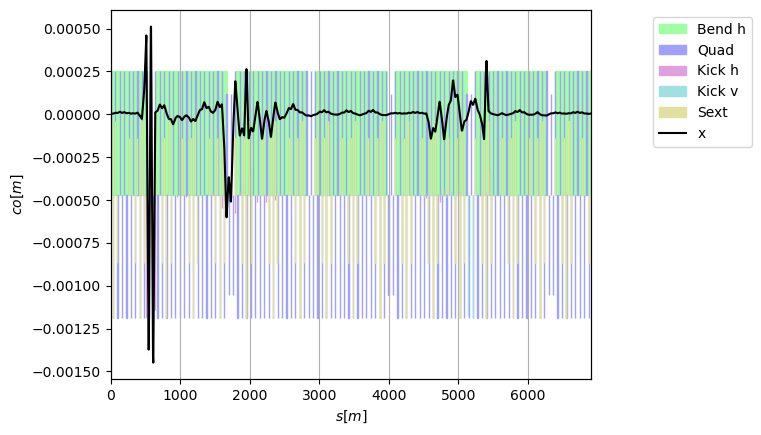

In [ ]:
line = xt.Line.from_json('off_mom_scan_line.json')
tt = line.get_table()

In [88]:
plane = 'DPneg'
bump = 2 # in mm
quad = 'qd.31110'

dir = Path(f'/Users/lisepauwels/sps_simulations/Prototyping/20251021/results/off_mom_scan/{quad}/{plane}/{bump}/')
num_particles = 100
num_turns = 6000
sweep = 6000

In [89]:
for nn in bump_strengths[quad]:
    line[f'kmdh{nn}'] += bump * bump_strengths[quad][nn]

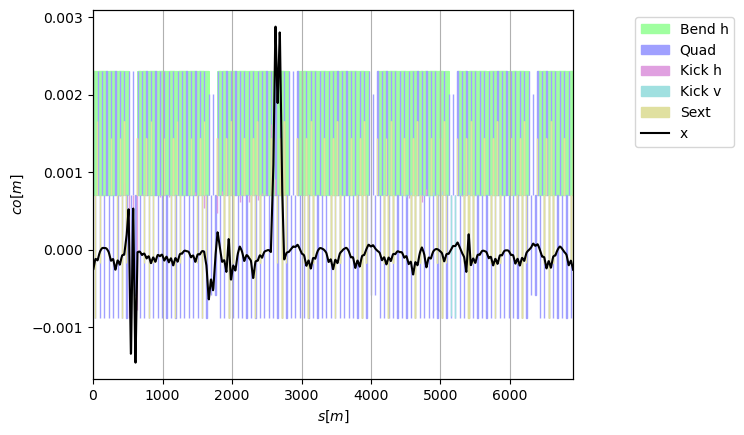

In [90]:
tw = line.twiss()
tw.plot('x')

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.28089940233432786


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.1 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 398.3s.
{'vcak.12501.b_aper': 1, 'lsd.22505.a_aper': 27, 'vcak.32501.a_aper': 16, 'vcak.42501.a_aper': 44, 'vcak.52501.a_aper': 3, 'lsd.52505.b_aper': 6, 'vcak.62501.a_aper': 3}


AttributeError: 'SweepLosses' object has no attribute 'result_name'

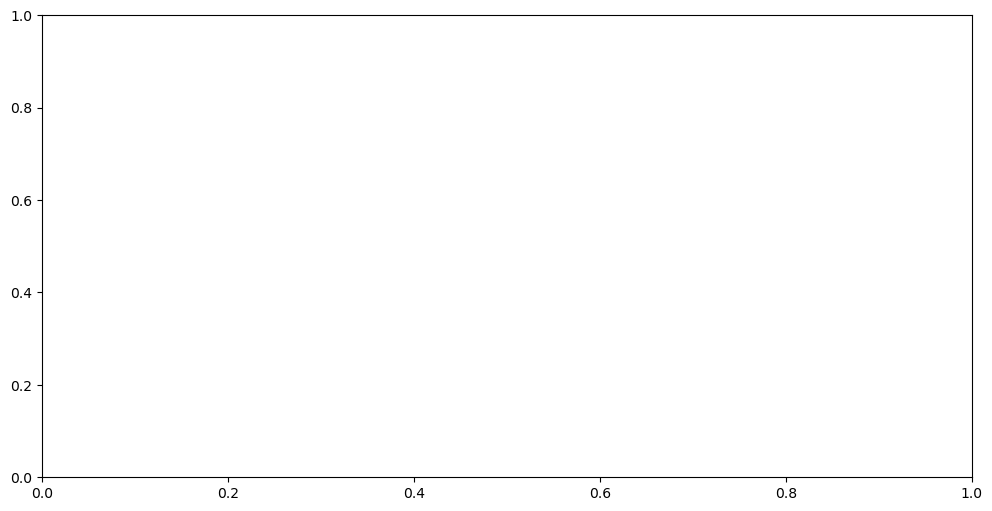

In [92]:
SL = SweepLosses(line, sweep=sweep, plane=plane, num_turns=num_turns, num_particles=num_particles, nemitt_x=2e-6, nemitt_y=2e-6, dir=dir, gaussian=True)

print(SL.aperture_losses)
SL.make_lossmap
SL.intensity_loss